In [50]:
import time
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp

import sympy
from scipy.constants import mu_0

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import CasingSimulations

from pymatsolver import Pardiso

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sigma_back = 1e-1 # wholespace

# top casing source
cp = CasingSimulations.CasingParameters(
    casing_l = 1000.,
    src_a = np.r_[0., np.pi, 0.], # the source fcts will take care of coupling it to the casing
    src_b = np.r_[1e3, np.pi, 0.], # return electrode  
    freqs = np.r_[1e-1, 0.5, 1., 2.],
    sigma_back = sigma_back, # wholespace
    sigma_layer = sigma_back,
    sigma_air = sigma_back,
    
)
print('Casing Parameters: ', cp.serialize())

('Casing Parameters: ', {'sigma_air': 0.1, 'layer_z': [-1000.0, -900.0], 'sigma_casing': 5500000.0, 'sigma_layer': 0.1, 'src_b': [1000.0, 3.141592653589793, 0.0], 'casing_t': 0.01, u'__class__': 'CasingParameters', 'src_a': [0.0, 3.141592653589793, 0.0], 'mur_casing': 100.0, 'casing_top': 0.0, 'sigma_inside': 1.0, 'sigma_back': 0.1, 'casing_l': 1000.0, 'casing_d': 0.1, 'freqs': [0.1, 0.5, 1.0, 2.0]})


In [10]:
print('skin depths in casing: ', cp.skin_depth(sigma=cp.sigma_casing, mu=cp.mur_casing*mu_0))
print('casing thickness: ',  cp.casing_t)

('skin depths in casing: ', array([ 0.0678639 ,  0.03034966,  0.02146045,  0.01517483]))
('casing thickness: ', 0.01)


In [14]:
print('skin depths in background: ', cp.skin_depth())

('skin depths in background: ', array([ 5032.92121045,  2250.79079039,  1591.54943092,  1125.3953952 ]))


# Set up meshes

In [19]:
npadx, npadz = 11, 22
dx2 = 200. 
csz = 0.25

mesh2D = CasingSimulations.CasingMesh(
    cp=cp, npadx=npadx, npadz=npadz, dx2=dx2, csz=csz
).mesh

In [20]:
print(mesh2D.vectorNz.min(), mesh2D.vectorNz.max(), mesh2D.vectorNx.max())

(-6610.6207320094109, 5613.1207320094109, 6712.31689453125)


In [21]:
ncy = 3
nstretchy = 3
stretchfact = 1.6
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

In [22]:
mesh3D = CasingSimulations.CasingMesh(
    cp=cp, npadx=npadx, npadz=npadz, dx2=dx2, hy=hy, csz=csz
).mesh

In [23]:
print(mesh2D.nC, mesh3D.nC)

(316212, 2845908)


In [24]:
mesh2D.vectorCCx.max()

5631.097412109375

In [25]:
# TODO: this should go into the cyl mesh view
self = mesh3D
NN = utils.ndgrid(self.vectorNx, self.vectorNy, np.r_[0])[:,:2]
NN = NN.reshape((self.vnN[0], self.vnN[1], 2), order='F')
NN = [NN[:,:,0], NN[:,:,1]]

In [26]:
print(NN[1].shape, self.nCx)

((79, 9), 78)


In [27]:
from discretize.utils import mkvc

In [28]:
X1 = np.c_[mkvc(NN[0][0, :]), mkvc(NN[0][self.nCx, :]), mkvc(NN[0][0, :])*np.nan].flatten()
Y1 = np.c_[mkvc(NN[1][0, :]), mkvc(NN[1][self.nCx, :]), mkvc(NN[1][0, :])*np.nan].flatten()

(0.0, 1000.0)

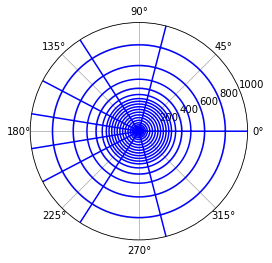

In [36]:
ax = plt.subplot(111, projection='polar')
ax.plot(Y1, X1, 'b-')
n = 100
xy2 = [ax.plot(np.linspace(0., np.pi*2, n), r*np.ones(n), '-b') for r in self.vectorNx]
ax.set_rlim([0., 1000.])

In [37]:
src2D = CasingSimulations.Sources.TopCasingSource(mesh2D, cp)

In [38]:
src3D = CasingSimulations.Sources.TopCasingSource(mesh3D, cp)

(-0.5, 0.5)

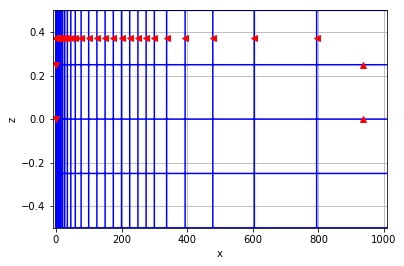

In [39]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src2D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-1., 1.])

(-0.5, 0.5)

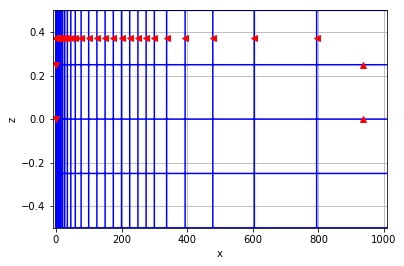

In [40]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src3D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-1., 1.])

In [41]:
# validate the source terms
src3D.validate()
src2D.validate()

True

(0.0, 1500)

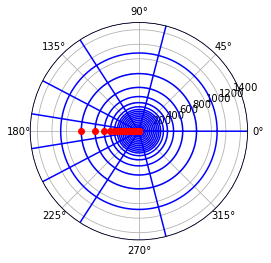

In [42]:
ax = plt.subplot(111, projection='polar')
ax.plot(Y1, X1, 'b-')
n = 100
xy2 = [ax.plot(np.linspace(0., np.pi*2, n), r*np.ones(n), '-b') for r in self.vectorNx[1:]]
ax.plot(mesh3D.gridFx[src3D.surface_wire,1], mesh3D.gridFx[src3D.surface_wire,0], 'ro')
ax.set_rlim([0., 1500])

# Look at physical properties on mesh

In [43]:
physprops2D = CasingSimulations.PhysicalProperties(mesh2D, cp)
physprops3D = CasingSimulations.PhysicalProperties(mesh3D, cp)

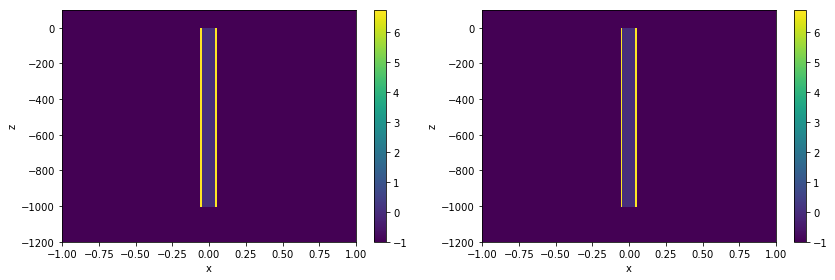

In [44]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(np.log10(physprops2D.sigma), ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

sigmaplt = physprops3D.sigma.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(np.log10(utils.mkvc(sigmaplt[:,0,:])), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

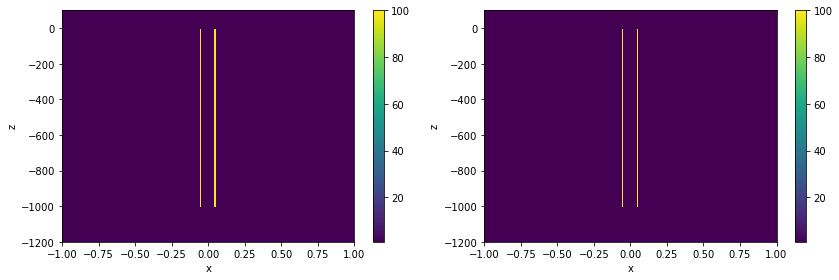

In [45]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(physprops2D.mur, ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

murplt = physprops3D.mur.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

# set up the forward simulation

In [46]:
prb2D = FDEM.Problem3D_h(
    mesh2D, sigmaMap=physprops2D.wires.sigma, muMap=physprops2D.wires.mu, Solver=Pardiso
)
prb3D = FDEM.Problem3D_h(
    mesh3D, sigmaMap=physprops3D.wires.sigma, muMap=physprops3D.wires.mu, Solver=Pardiso
)

In [47]:
survey2D = FDEM.Survey(src2D.srcList)
survey3D = FDEM.Survey(src3D.srcList)

In [48]:
prb2D.pair(survey2D)
prb3D.pair(survey3D)

In [51]:
t = time.time()
fields2D = prb2D.fields(physprops2D.model)
np.save('fields2DMultiFreqtopCasing', fields2D[:, 'hSolution'])
print('Elapsed time for 2D: {}'.format(time.time()-t))

Elapsed time for 2D: 13.9663479328


In [28]:
# %%time
t = time.time()
fields3D = prb3D.fields(physprops3D.model)
np.save('fields2DMultiFreqtopCasing', fields3D[:, 'hSolution'])
print('Elapsed time for 3D: {}'.format(time.time()-t))

In [29]:
h2D = np.load('fields2DMultiFreqtopCasing.npy')
h3D = np.load('fields3DMultiFreqtopCasing.npy')

In [30]:
prb2D.model = physprops2D.model
fields2D = prb2D.fieldsPair(mesh2D, survey2D)
fields2D[:, 'hSolution'] = h2D

In [31]:
prb3D.model = physprops3D.model
fields3D = prb3D.fieldsPair(mesh3D, survey3D)
fields3D[:, 'hSolution'] = h3D

In [101]:
from matplotlib.colors import LogNorm

def plotJ2D(
    j, real_or_imag='real', ax=None, range_x=np.r_[0., 1000.], 
    range_y=np.r_[-2000., 0.], sample_grid=np.r_[5., 5.],
    logScale=True
):
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(10, 4))
        
    if len(j) == mesh2D.nF:
        vType = 'F'
    elif len(j) == mesh2D.nC*2:
        vType = 'CCv'
    
    if logScale is True:
        pcolorOpts = {
                'norm':LogNorm()
        }
    else:
        pcolorOpts = {}
        
    
    plt.colorbar(
    mesh2D.plotImage(
            getattr(j, real_or_imag), 
            view='vec', vType=vType, ax=ax, 
            range_x=range_x, range_y=range_y, sample_grid=sample_grid, 
            mirror=False, 
            pcolorOpts=pcolorOpts,
        )[0], ax=ax
    )

In [120]:
def plotH2D(
    h, real_or_imag='real', ax=None, range_x=np.r_[0., 1000.], 
    range_y=np.r_[-2000., 0.], sample_grid=np.r_[5., 5.],
    logScale=True
):
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(10, 4))
        
    if len(j) == mesh2D.nE:
        vType = 'E'
    elif len(j) == mesh2D.nC:
        vType = 'CC'
    
    if logScale is True:
        pcolorOpts = {
            'norm':LogNorm()
        }
    else:
        pcolorOpts = {}
        
    
    plt.colorbar(
    mesh2D.plotImage(
            getattr(h, real_or_imag), 
            view='real', vType=vType, ax=ax, 
            range_x=range_x, range_y=range_y, sample_grid=sample_grid, 
            mirror=False, 
            pcolorOpts=pcolorOpts,
        )[0], ax=ax
    )

In [125]:
def getJ3DthetaSlice(j3D, theta_ind=0):
    j3D_x = j3D[:mesh3D.nFx].reshape(mesh3D.vnFx, order='F')
    j3D_z = j3D[mesh3D.vnF[:2].sum():].reshape(mesh3D.vnFz, order='F')
    
    j3Dslice = np.vstack([utils.mkvc(j3D_x[:,theta_ind,:],2), utils.mkvc(j3D_z[:,theta_ind,:],2)])
    
    return j3Dslice

def getH3DthetaSlice(h3D, theta_ind=0):
    h3D_y = h3D[mesh3D.nEx:mesh3D.vnE[:2].sum()].reshape(mesh3D.vnEy, order='F')
    
    return mkvc(h3D_y[:,theta_ind,:])

In [126]:
theta_ind = 3
j3Dplt = getJ3DthetaSlice(fields3D[:,'j'], theta_ind=theta_ind)
h3Dplt = getH3DthetaSlice(fields3D[:,'h'], theta_ind=theta_ind)

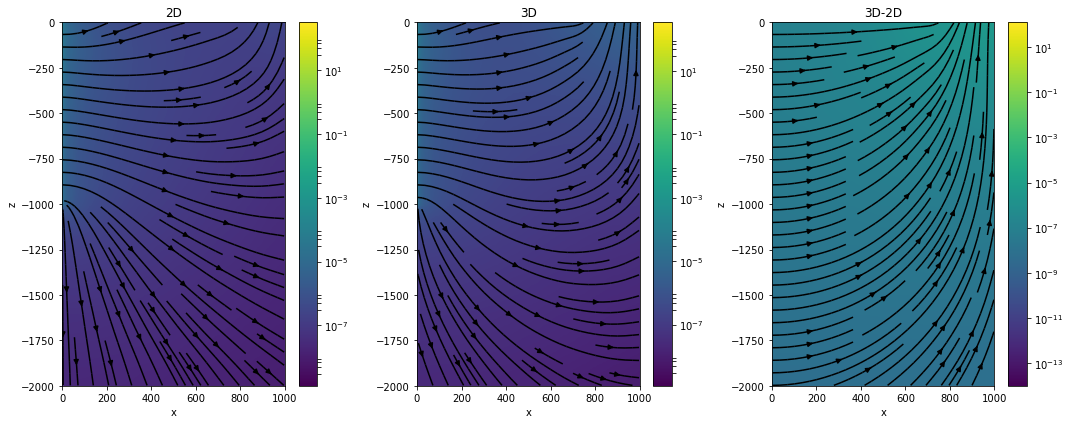

In [117]:
real_or_imag = 'real'

fig, ax = plt.subplots(1,3,figsize=(15,6))

[
    plotJ2D(f, real_or_imag=real_or_imag, logScale=True, ax=a) for f, a in zip(
        [fields2D[:,'j'], j3Dplt, j3Dplt - fields2D[:,'j']], ax
    )
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

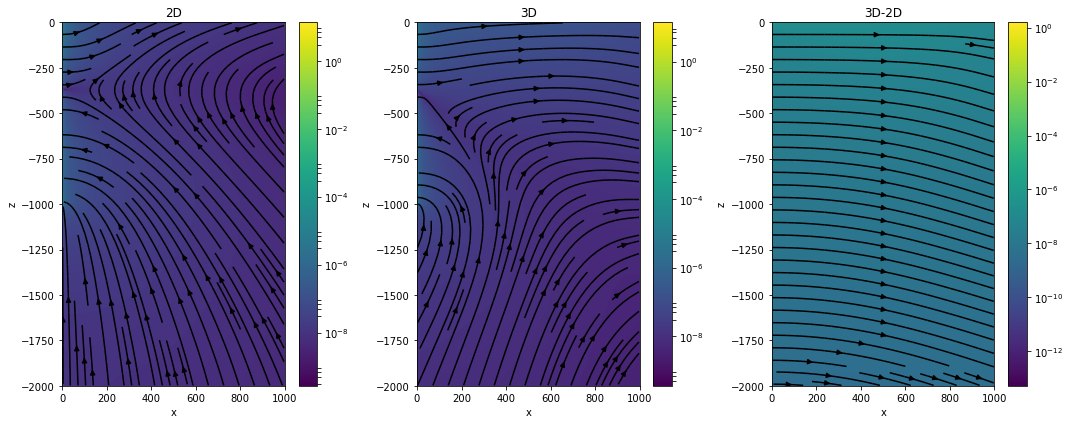

In [118]:
real_or_imag = 'imag'

fig, ax = plt.subplots(1,3,figsize=(15,6))

[
    plotJ2D(f, real_or_imag=real_or_imag, logScale=True, ax=a) for f, a in zip(
        [fields2D[:,'j'], j3Dplt, j3Dplt - fields2D[:,'j']], ax
    )
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

In [ ]:
real_or_imag = 'real'

fig, ax = plt.subplots(1,3,figsize=(15,6))

[
    plotH2D(f, real_or_imag=real_or_imag, logScale=True, ax=a) for f, a in zip(
        [fields2D[:,'h'], h3Dplt, h3Dplt - fields2D[:,'h']], ax
    )
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

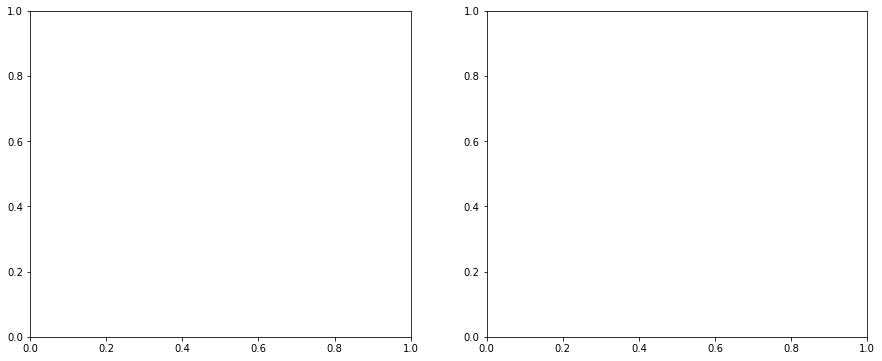

In [119]:
# look at the horizontalcurrent density at some radius away from the well
fig, ax = plt.subplots(1,2,figsize=(15,6))

rind = 10.
print 

ax[0]